In [1]:
cd ..

/master


In [2]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
#%load_ext autoreload
#%autoreload 2
#%pdb

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(8)

Autosaving every 600 seconds


# Conditional Neural Process 1D - Gaussian Process Samples

last update: 08 June 2019

**Aim**: This notebook shows how to train and sample from a Conditional Neural Process (no latents) for a simple class of 1D functions. The functions are sampled from a Gaussian process with various kernels.


In [3]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic, ExpSineSquared, 
                                              DotProduct, ConstantKernel)

from skssl.transformers import NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess
from skssl.predefined import MLP
from skssl.transformers.neuralproc.datasplit import context_target_split

from ntbks_datasets import GPDataset
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

In [4]:
x_dim = 1
y_dim = 1
r_dim = 64
batch_size = 64
num_points = 128
num_samples = 20000
n_epochs = 10


def _DeepMLP(*args):
    return MLP(*args, hidden_size=r_dim, n_hidden_layers=3)


def get_cntxt_trgt(*args):
    return context_target_split(*args,
                                range_cntxts=(4, 50),
                                range_extra_trgts=(num_points-50, num_points-50))


def get_model(x_dim, y_dim):
    return NeuralProcess(x_dim, y_dim,
                         XYEncoder=_DeepMLP,
                         Decoder=_DeepMLP,
                         r_dim=r_dim,
                         LatentEncoder=MLP,
                         get_cntxt_trgt=get_cntxt_trgt,
                        encoded_path="deterministic")


data_models = dict()
data_models["rbf"] = (get_model(x_dim, y_dim),
                      GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                                 length_scale_bounds=(1e-1, 10.0)),
                                num_samples=num_samples,
                                num_points=num_points))
data_models["periodic"] = (get_model(x_dim, y_dim),
                           GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                                 periodicity=3.0,
                                                                 length_scale_bounds=(0.1, 10.0),
                                                                 periodicity_bounds=(1.0, 10.0)),
                                     num_samples=num_samples,
                                     num_points=num_points))
data_models["non-stationary"] = (get_model(x_dim, y_dim),
                                 GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                                   (DotProduct(sigma_0=1.0,
                                                               sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                           num_samples=num_samples,
                                           num_points=num_points))
data_models["matern"] = (get_model(x_dim, y_dim),
                         GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                       length_scale_bounds=(1e-1, 10.0),
                                                       nu=1.5),
                                   num_samples=num_samples,
                                   num_points=num_points))


##  Data

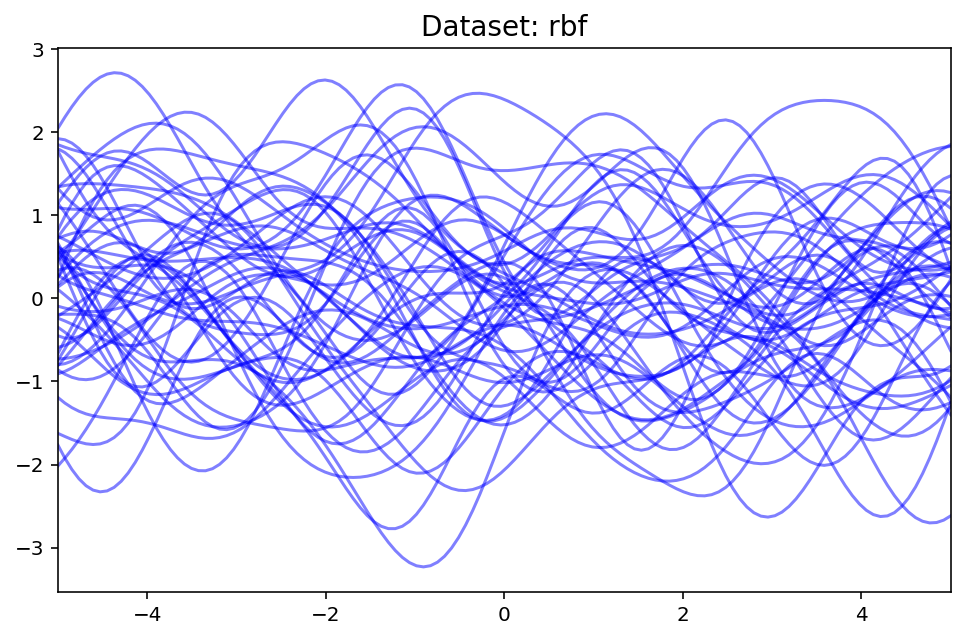

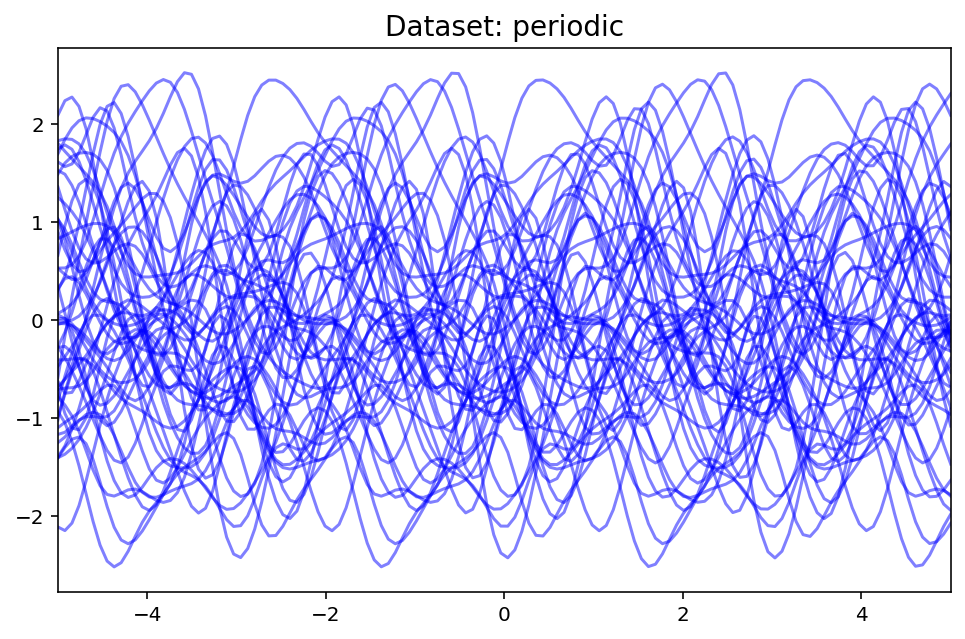

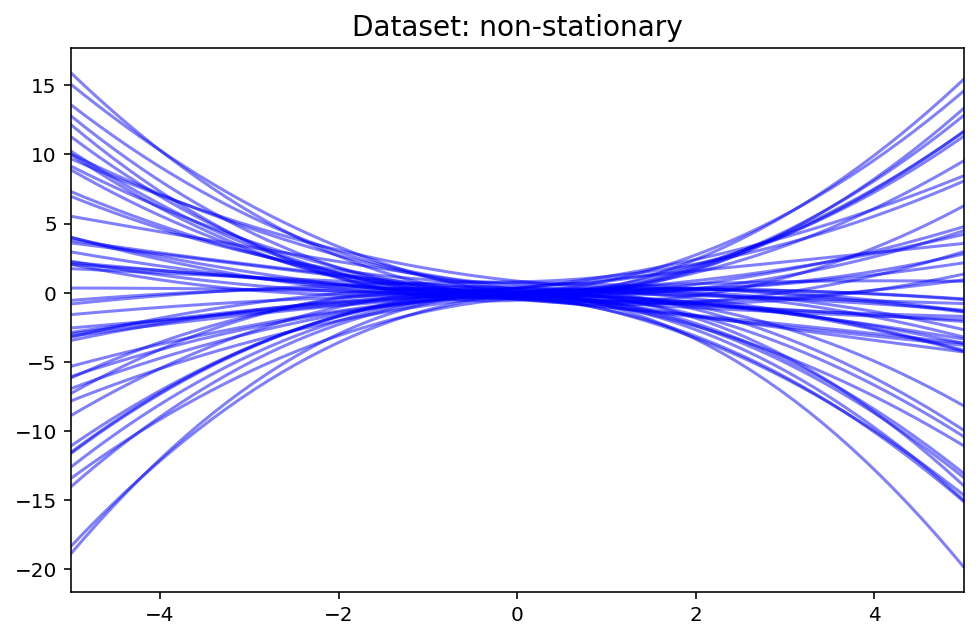

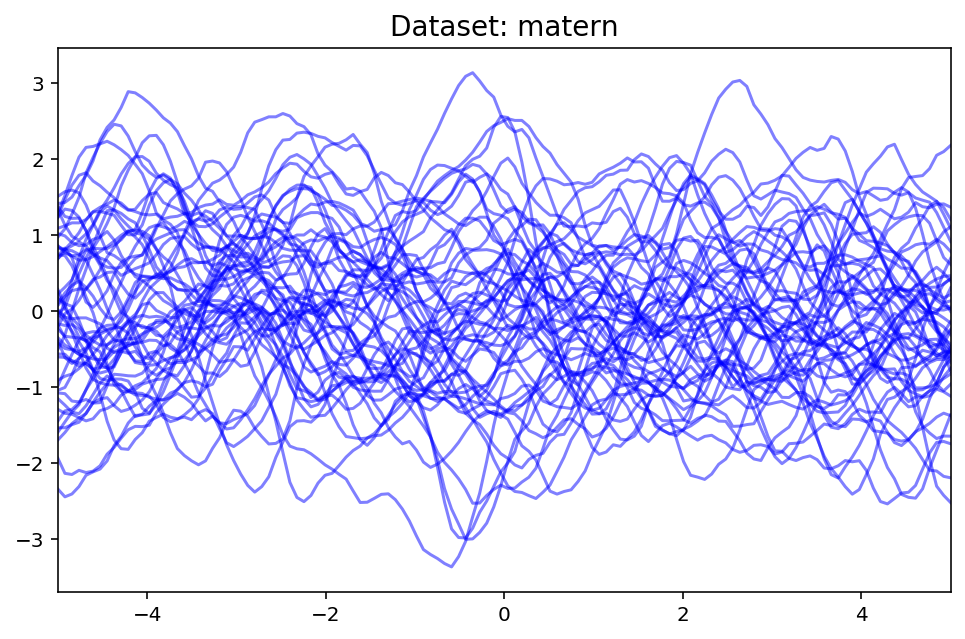

In [5]:
for k,(neural_proc, dataset) in data_models.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Prior Samples

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

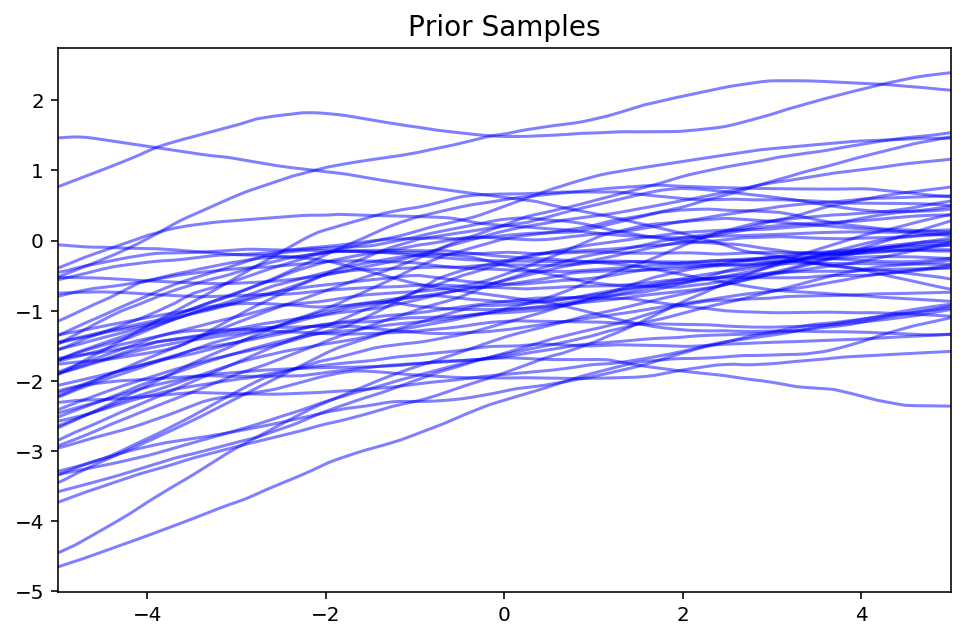

In [6]:
plot_prior_samples(neural_proc, r_dim, min_max=dataset.min_max)

## Training

In [7]:
from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- Training {} ---".format(k))
    print()
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=n_epochs,
                                 batch_size=batch_size,
                                train_split=None)  # no dev set
    
    _=model.fit(*make_Xy_input(dataset))


--- Training rbf ---



  epoch    train_loss     dur
-------  ------------  ------
      1      156.7520  3.2054


      2      135.0584  3.0055


      3      125.8486  3.0706


      4      122.2663  3.2448


      5      116.1958  3.1572


      6      112.6895  3.0109


      7      104.2253  2.9837


      8      102.8310  3.1089


      9       98.1200  2.8520


     10       91.3710  2.7035

--- Training periodic ---



  epoch    train_loss     dur
-------  ------------  ------
      1      143.2932  2.8112


      2      134.9856  2.7472


      3      133.7821  2.5861


      4      132.8866  2.6066


      5      134.4535  2.1829


      6      132.6764  2.7108


      7      131.8620  2.5315


      8      130.9734  2.7425


      9      130.8739  2.6769


     10      130.4706  2.5161

--- Training non-stationary ---



  epoch    train_loss     dur
-------  ------------  ------
      1      283.0610  2.7183


      2      177.2105  2.6864


      3      130.0362  2.7995


      4       99.7764  2.7136


      5       99.3827  2.5875


      6       85.0947  2.4323


      7       77.6989  2.5451


      8       69.6206  2.3260


      9       64.1918  2.1798


     10       59.8147  2.2375

--- Training matern ---



  epoch    train_loss     dur
-------  ------------  ------
      1      197.5224  2.3081


      2      154.0198  2.2234


      3      146.2078  2.2357


      4      143.5476  2.0450


      5      144.8110  2.4000


      6      137.5798  2.0101


      7      133.6142  2.3018


      8      133.2957  2.2575


      9      131.8705  2.3185


     10      128.7755  2.2141


## Trained Prior 
The prior should now encode some information about the shapes of the functions.

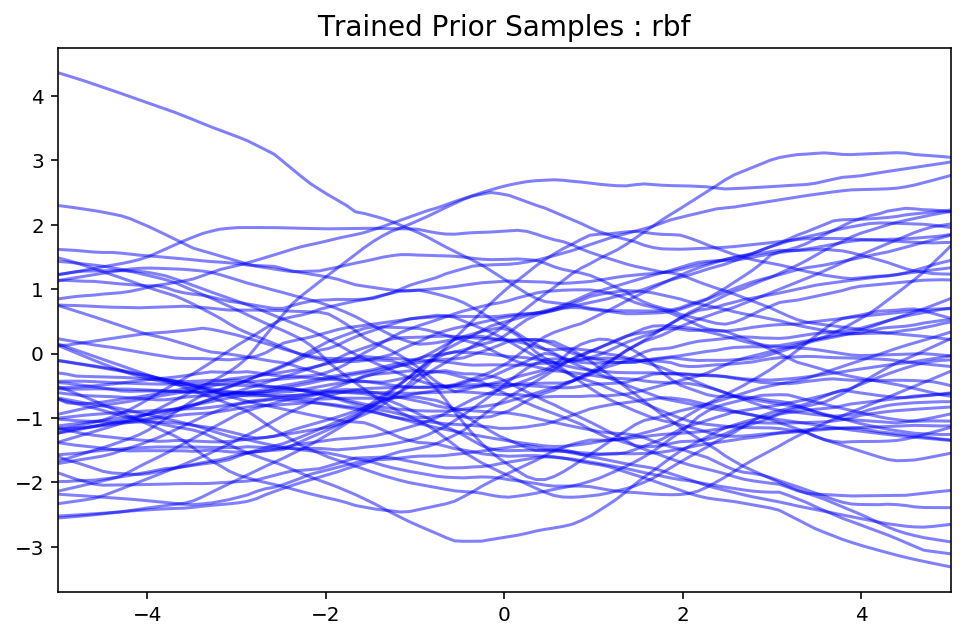

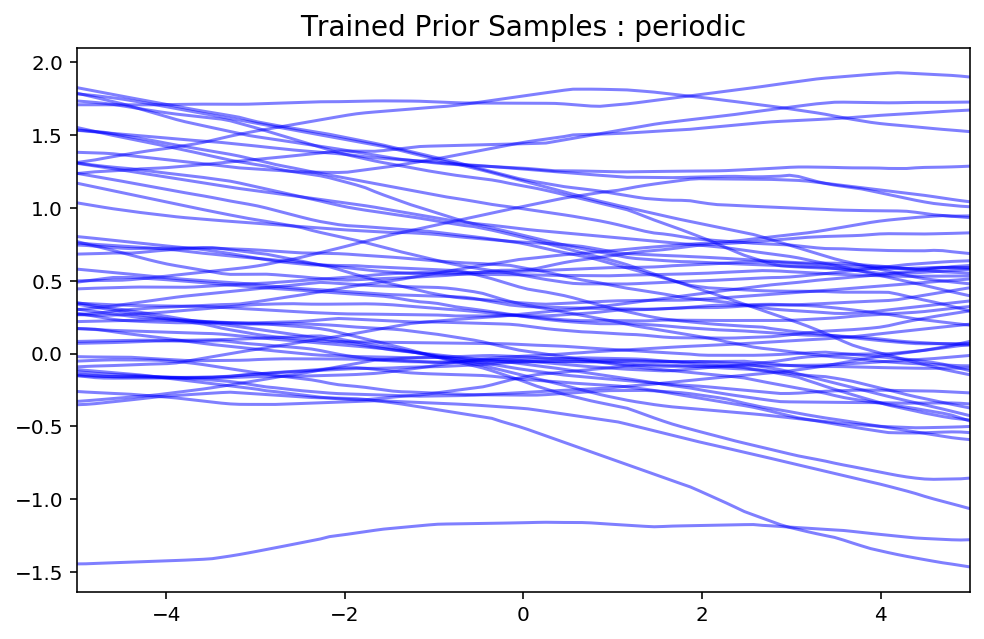

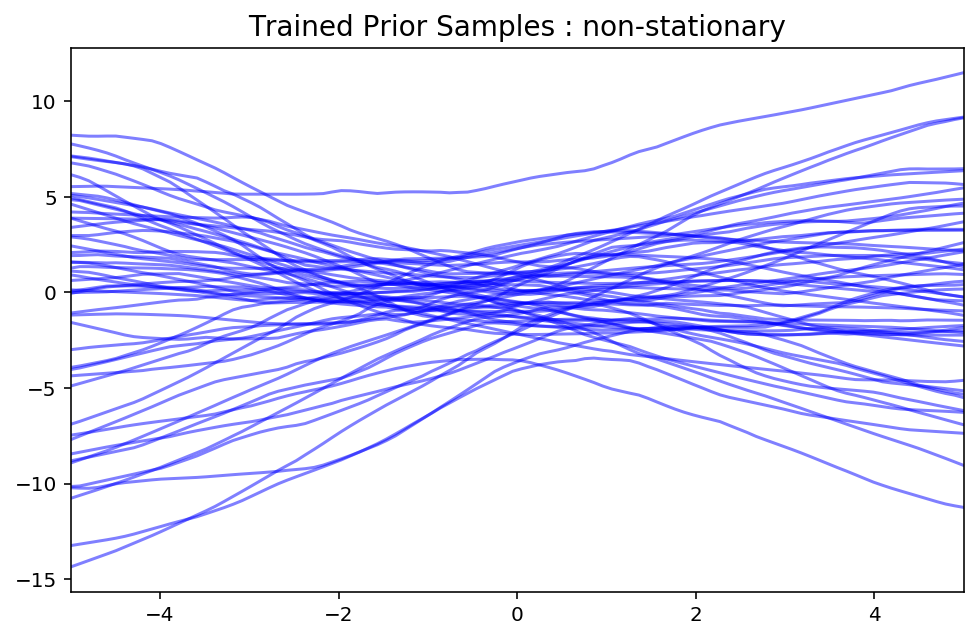

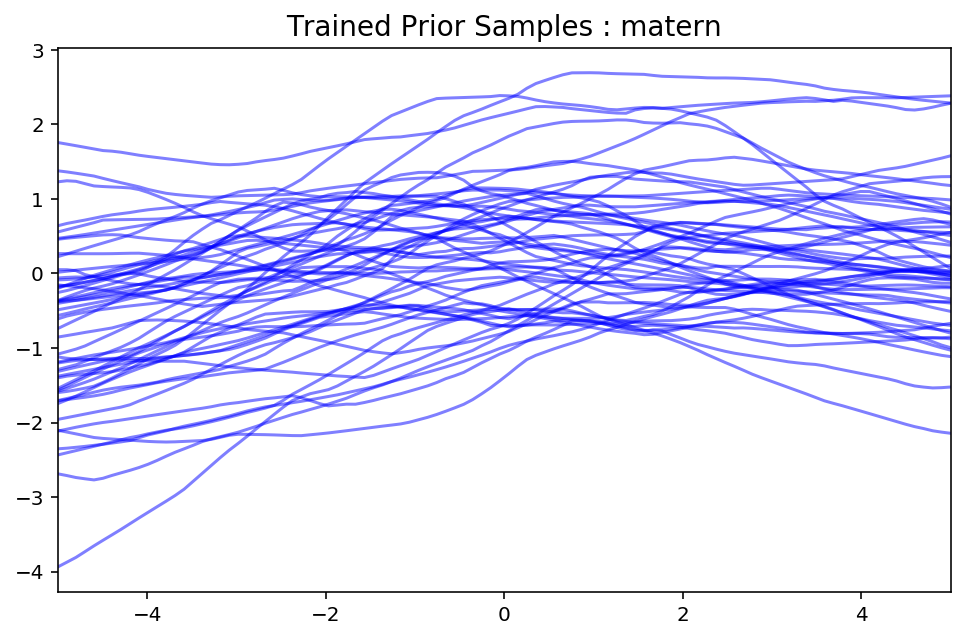

In [8]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, r_dim, title="Trained Prior Samples : {}".format(k))

## Posterior

std: 0.87892556
std: 1.0017252
std: 0.66268533
std: 0.72092164


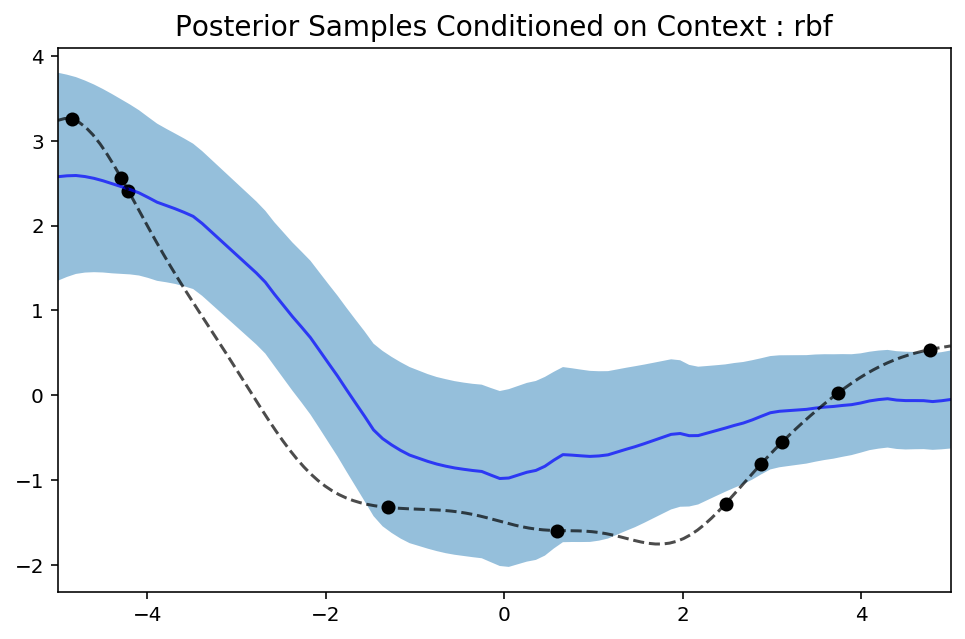

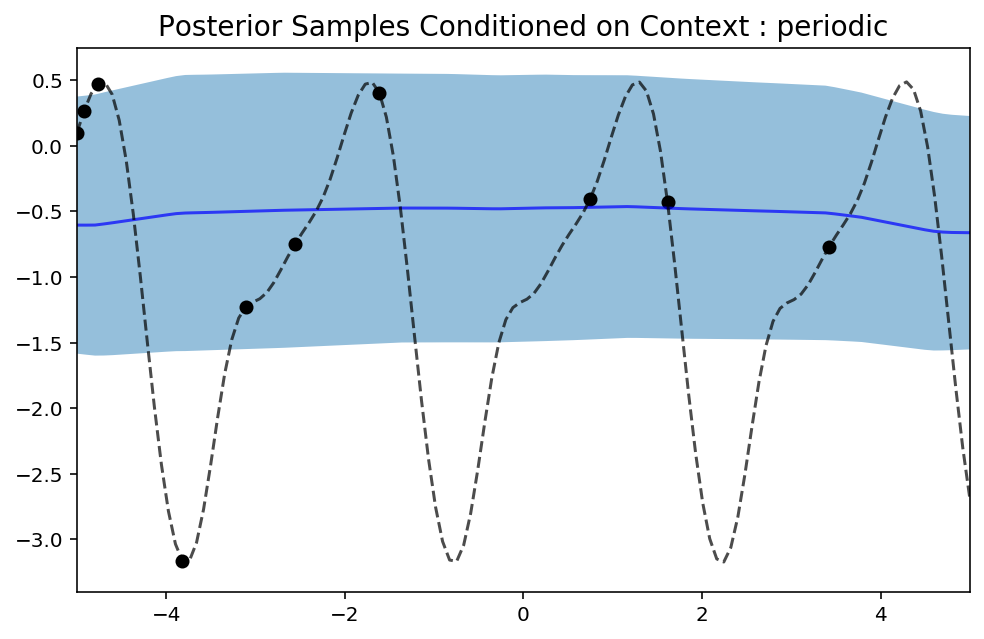

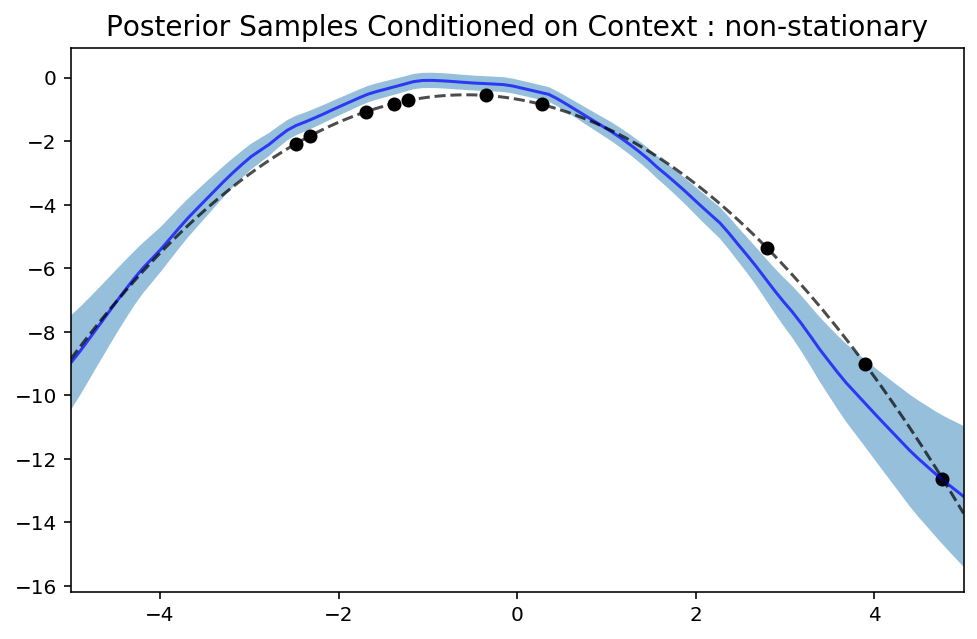

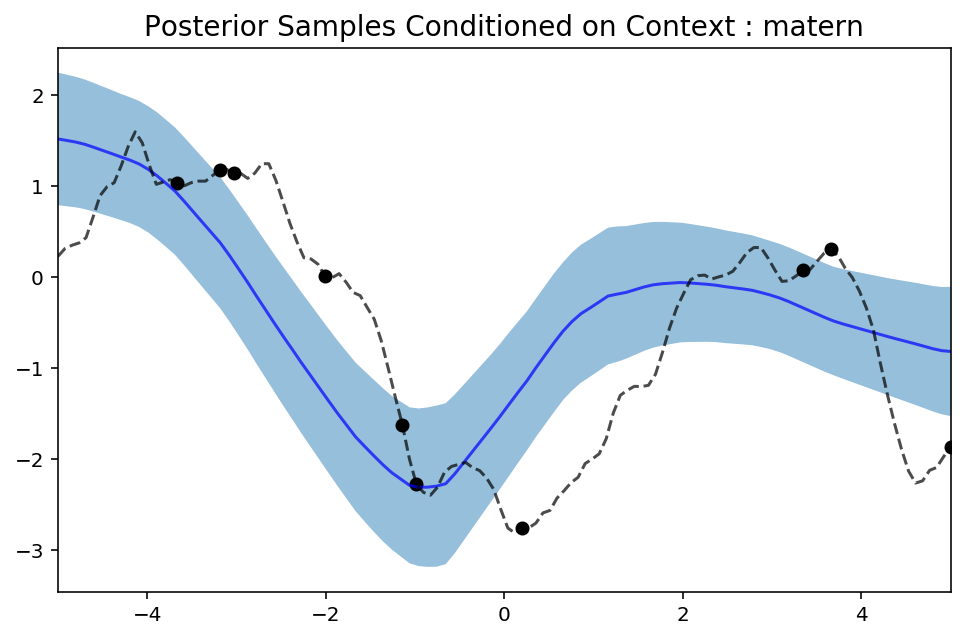

In [9]:
n_cntxt = 10

for k,(neural_proc, dataset) in data_models.items():
    
    for X, Y in model.get_iterator(dataset, training=False):
        break
    X, Y = X[0:1], Y[0:1]
    n_points = X.size(1)
    idx = torch.randperm(n_points)[:n_cntxt]
    X_cntxt, Y_cntxt = X[:,idx,:], Y[:,idx,:]
    
    plot_posterior_samples(neural_proc, X_cntxt, Y_cntxt, true_func=(X,Y),  n_samples=1, is_plot_std=True,
                           title="Posterior Samples Conditioned on Context : {}".format(k))

Let's now use a single context point to see how much information is in the "learned implicit kernel"

std: 0.76124936
std: 0.4910367
std: 1.6963952
std: 0.8197306


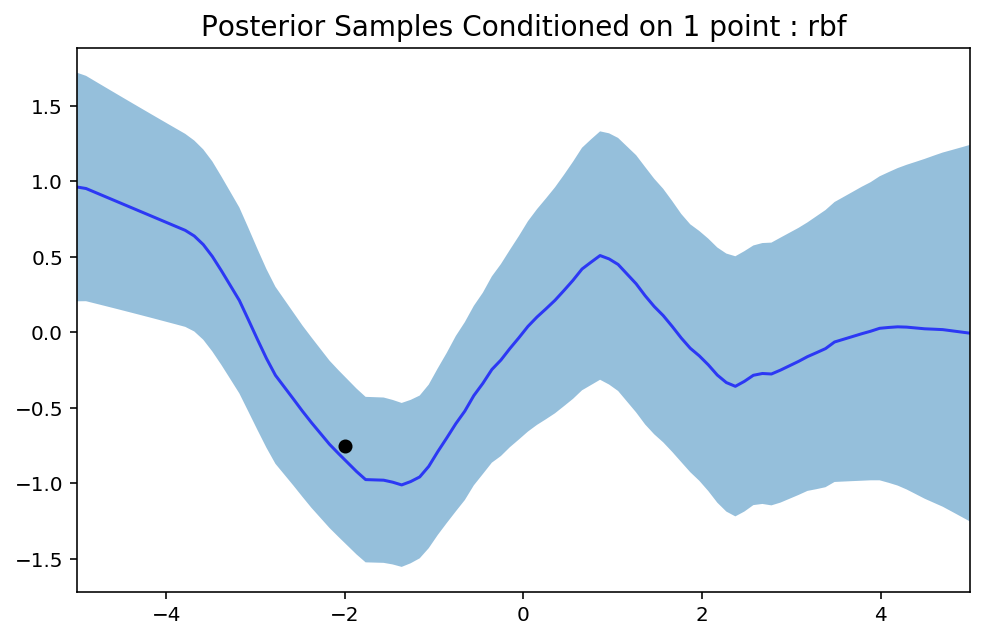

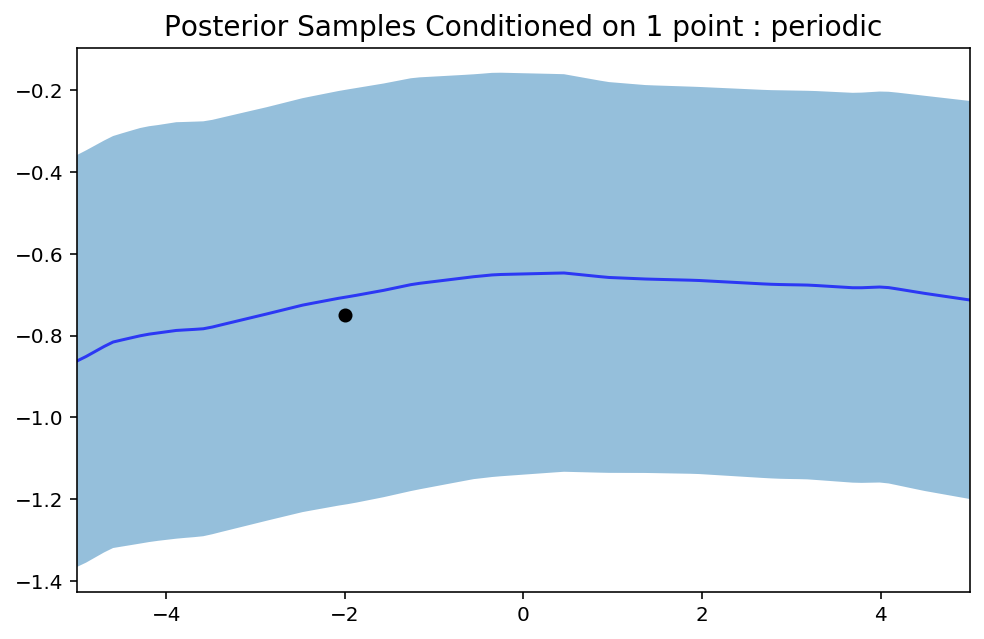

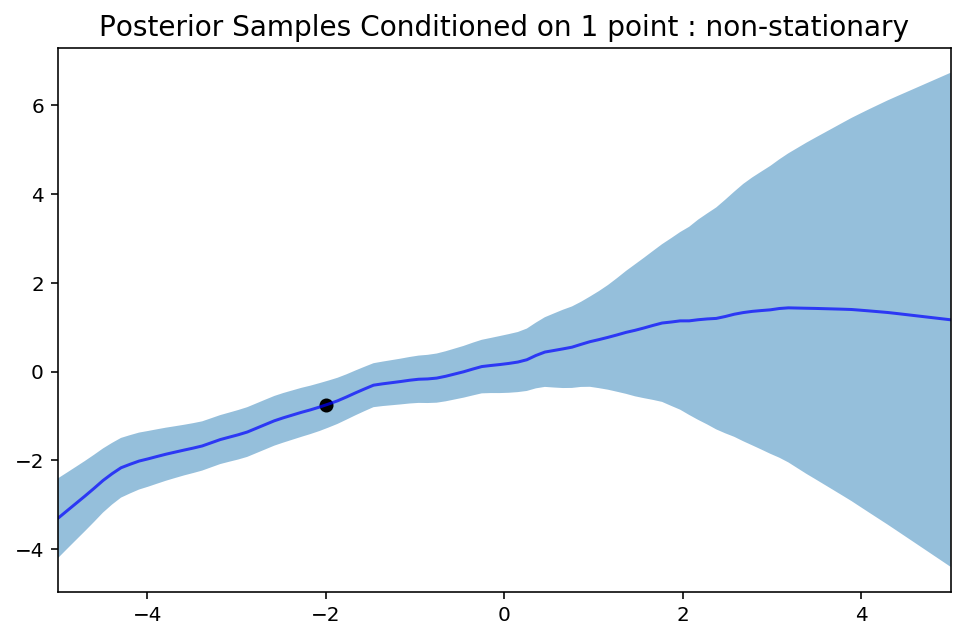

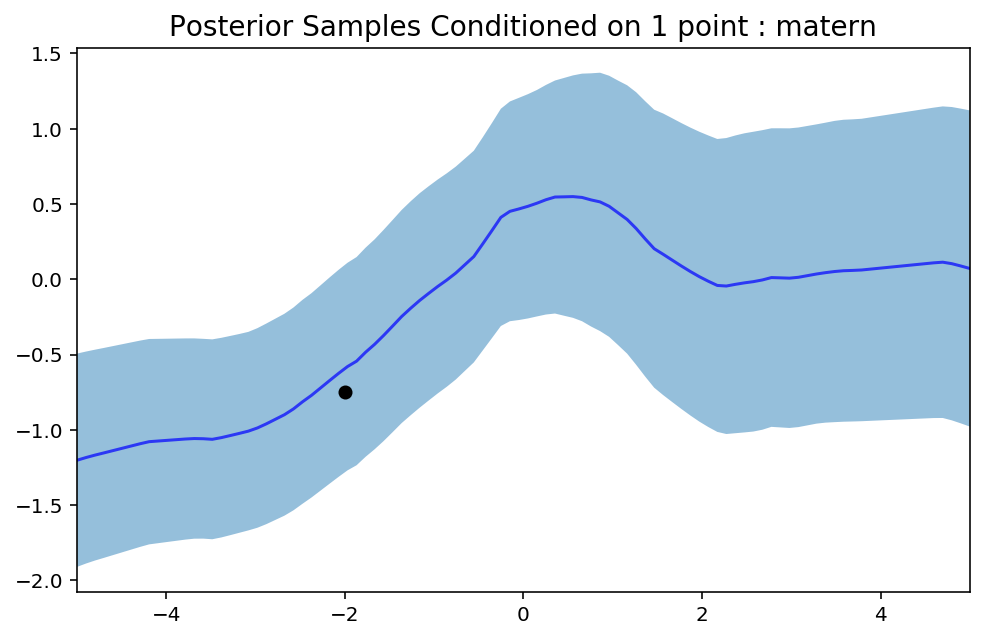

In [10]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[-0.75]]]),  
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))

std: 0.9188232
std: 0.48748013
std: 1.8148935
std: 0.87407404


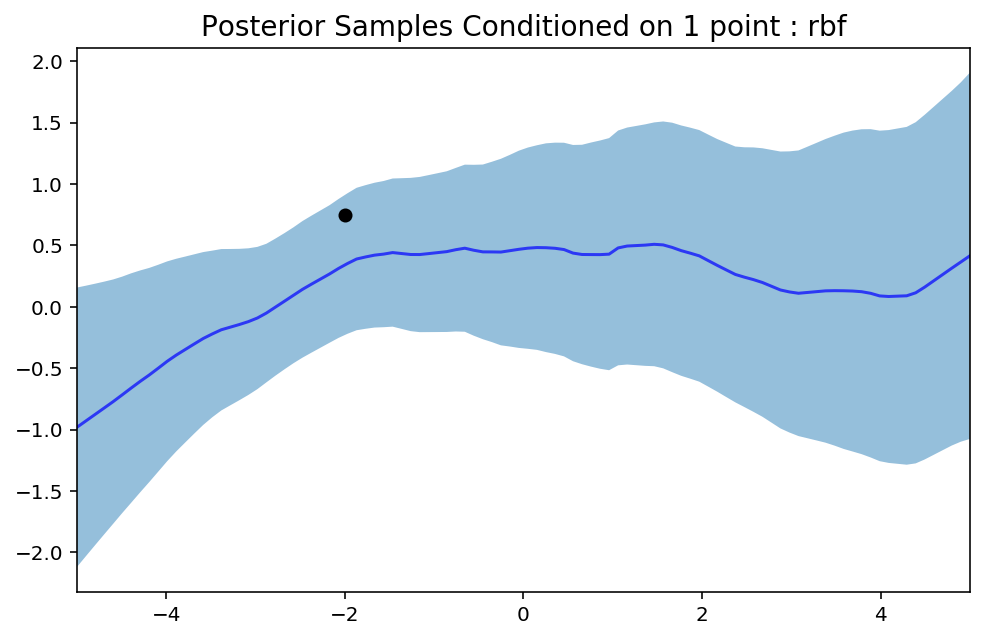

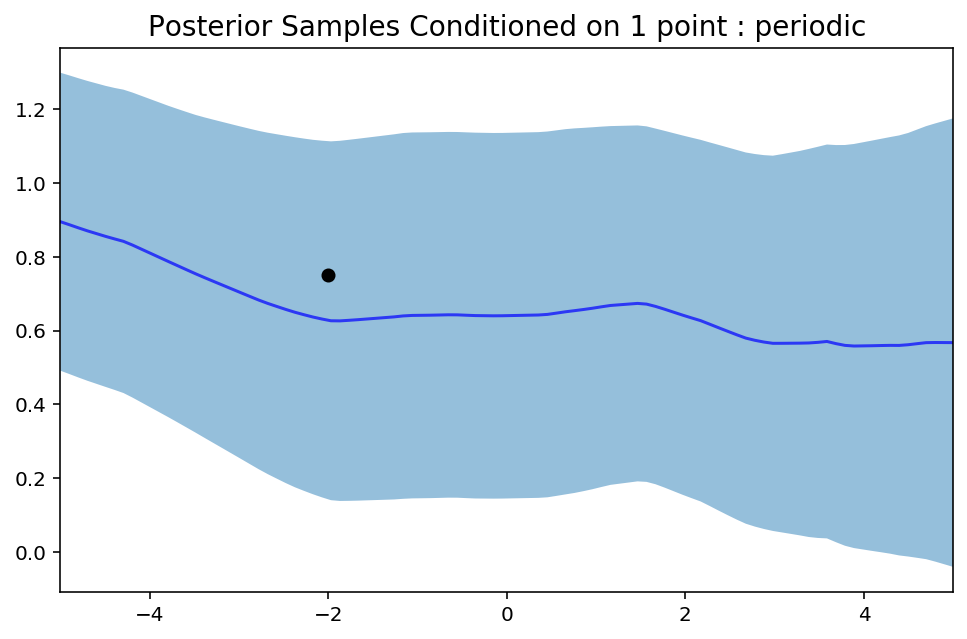

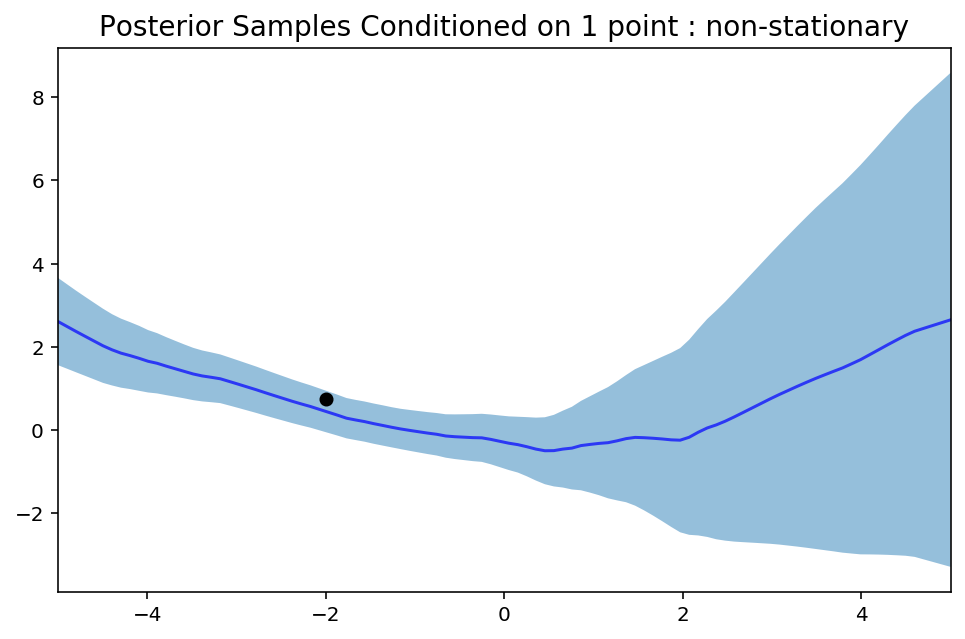

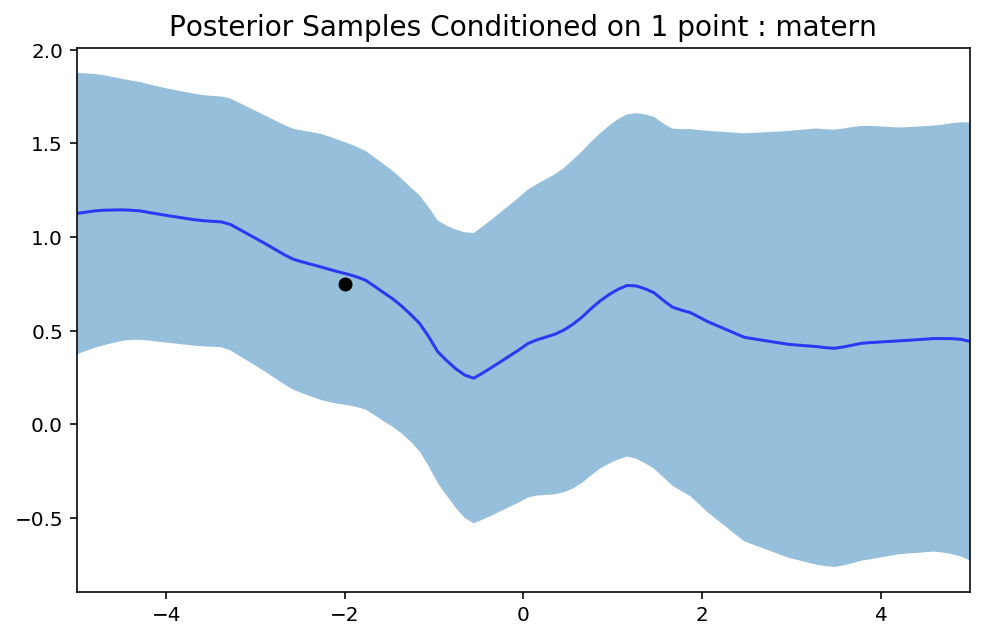

In [11]:
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(neural_proc, torch.tensor([[[-2.]]]), torch.tensor([[[0.75]]]), 
                           is_plot_std=True, n_samples=1,
                           title="Posterior Samples Conditioned on 1 point : {}".format(k))